<a href="https://colab.research.google.com/github/ioloi1128/CDA/blob/main/CDA_week9_EOF_partI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [118]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import pandas as pd

import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point

Read in monthly SST

In [119]:
#url = 'http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/noaa.oisst.v2/sst.mnmean.nc'
#ds = xr.open_dataset(url)
ds = xr.open_dataset("sst.mon.mean.oisstnan.nc")

# select period
ds = ds.sel(time=slice('1980', '2000'))

#actually load the data
ds.load()
#ds.to_netcdf("sst.mon.mean.oisstnan.nc")

<xarray.Dataset>
Dimensions:    (lat: 180, lon: 360, time: 229, nbnds: 2)
Coordinates:
  * lat        (lat) float32 89.5 88.5 87.5 86.5 ... -86.5 -87.5 -88.5 -89.5
  * lon        (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * time       (time) datetime64[ns] 1981-12-01 1982-01-01 ... 2000-12-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) datetime64[ns] 1981-12-01 1982-01-01 ... 2001-01-01
    sst        (time, lat, lon) float32 -1.79 -1.79 -1.79 ... -1.79 -1.79 -1.79
Attributes:
    title:                           NOAA Optimum Interpolation (OI) SST V2
    Conventions:                     CF-1.0
    history:                         Wed Apr  6 13:47:45 2005: ncks -d time,0...
    comments:                        Data described in  Reynolds, R.W., N.A. ...
    platform:                        Model
    source:                          NCEP Climate Modeling Branch
    institution:                     National Centers for Environmental Predi...
    References:                      https://www.psl.noaa.gov/data/gridded/da...
    dataset_title:                   NOAA Optimum Interpolation (OI) SST V2
    source_url:                      http://www.emc.ncep.noaa.gov/research/cm...
    DODS_EXTRA.Unlimited_Dimension:  time

Make anomalies

In [120]:
ds_climo=ds.groupby('time.month').mean()
ds_anoms=ds.groupby('time.month')-ds_climo
ds_anoms

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, time: 229)
Coordinates:
  * lat      (lat) float32 89.5 88.5 87.5 86.5 85.5 ... -86.5 -87.5 -88.5 -89.5
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * time     (time) datetime64[ns] 1981-12-01 1982-01-01 ... 2000-12-01
    month    (time) int64 12 1 2 3 4 5 6 7 8 9 10 ... 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    sst      (time, lat, lon) float32 5.96e-07 5.96e-07 ... 5.96e-07 5.96e-07

Reversed latitudes

In [121]:
ds_anoms=ds_anoms.reindex(lat=list(reversed(ds_anoms['lat'])))

Select Tropical Pacific Region

<xarray.Dataset>
Dimensions:  (lat: 60, lon: 250, time: 229)
Coordinates:
  * lat      (lat) float32 -29.5 -28.5 -27.5 -26.5 -25.5 ... 26.5 27.5 28.5 29.5
  * lon      (lon) float32 30.5 31.5 32.5 33.5 34.5 ... 276.5 277.5 278.5 279.5
  * time     (time) datetime64[ns] 1981-12-01 1982-01-01 ... 2000-12-01
    month    (time) int64 12 1 2 3 4 5 6 7 8 9 10 ... 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    sst      (time, lat, lon) float32 -0.09 -0.029 0.1415 ... -0.622 -0.4825


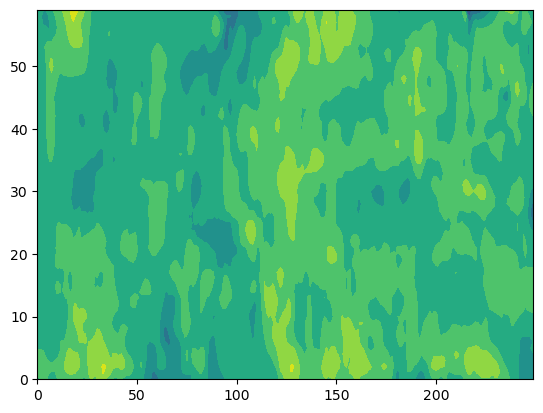

In [136]:
ds_tpac=ds_anoms.sel(lat=slice(-30,30),lon=slice(30,280))
plt.contourf(ds_tpac['sst'][0,:,:])
ds_tpac
print(ds_tpac)

Weight data

In [123]:
coslat = np.cos(np.deg2rad(ds_tpac.coords['lat'].values))
wgts = np.sqrt(coslat)[..., np.newaxis]
ds_sst = ds_tpac['sst']
ds_sst=ds_sst*wgts
#wgts.shape

Reshape to [time,space]

In [124]:
nx=len(ds_sst['lon'])
ny=len(ds_sst['lat'])
nt=len(ds_sst['time'])
X=np.reshape(ds_sst.values,((nt,ny*nx)))
X.shape

(229, 15000)

Calculation of EOFs

Calculate the Covariance Matrix

In [125]:
C=np.cov(X)
C.shape

(229, 229)

Calculate the eigenvalues and vectors of the Covariance Matrix

In [126]:
from numpy import linalg as LA

In [127]:
eigenvalues,eigenvectors=LA.eig(C)

Sort eigenvalues and eigenvectors

In [128]:
idx = eigenvalues.argsort()[::-1]   
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:,idx]

Get the PC Temporal Patterns

In [129]:
PC=eigenvectors
PC.shape

(229, 229)

Plot the first PC (the one with the most variance)

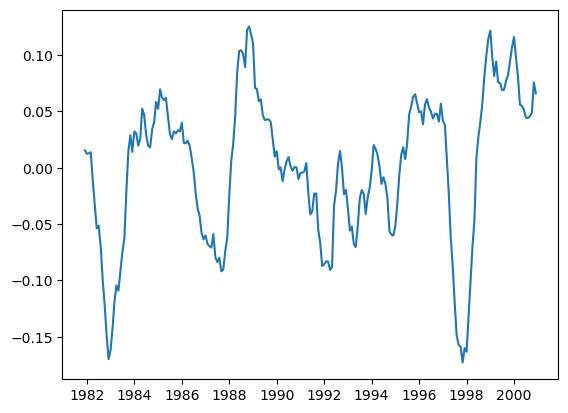

In [130]:
plt.plot(ds_anoms['time'],PC[:,0])

Get the EOF Spatial Patterns

In [131]:
EOF=np.dot(X.T,PC)
EOF=EOF.reshape((ny,nx,nt)).T/wgts.squeeze()
EOF.shape

(229, 250, 60)

Plot the first EOF (the one with the most variance)

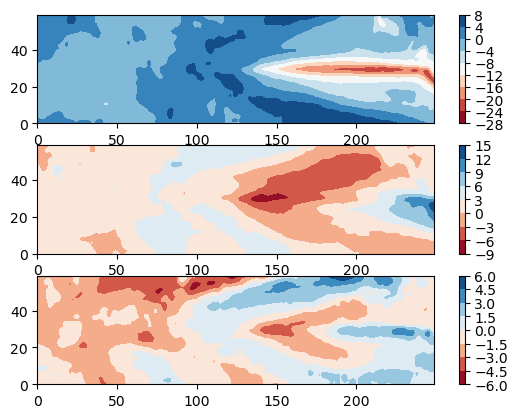

In [132]:
nrows=3
ncols=1
clevs=np.arange(-20,21,10)

for i in np.arange(3):
    plt.subplot(nrows,ncols,i+1)
    plt.contourf(EOF[i,:,:].T,cmap='RdBu')
    plt.colorbar()

Get the variance explained by each eigenvector

[34.33443116 10.53735008  4.08574991  3.77723239  3.18924273  2.63126807
  2.19878242  2.14794283  1.78802596  1.57818816]


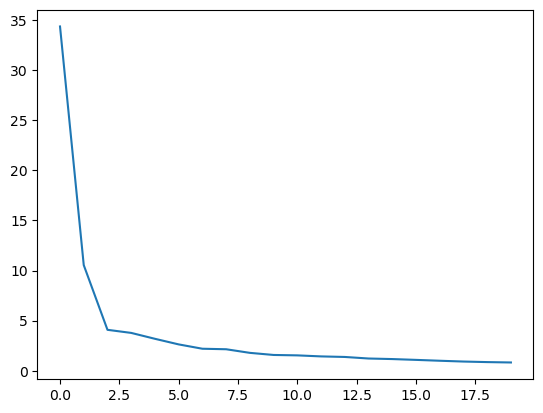

In [133]:
vexp=eigenvalues/np.sum(eigenvalues)
plt.plot(vexp[0:20]*100)
print(vexp[0:10]*100)

Presenting EOFs

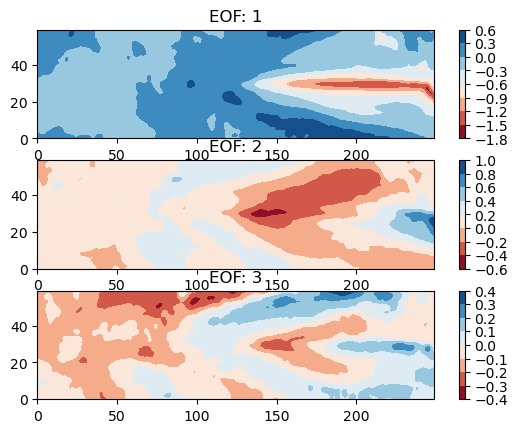

In [134]:
nrows=3
ncols=1
clevs=np.arange(-20,21,10)

for i in np.arange(3):
    plt.subplot(nrows,ncols,i+1)
    eofnorm=EOF[i,:,:].T*np.std(PC[:,i])
    plt.contourf(eofnorm,cmap='RdBu')
    plt.title('EOF: '+str(i+1))
    plt.colorbar()

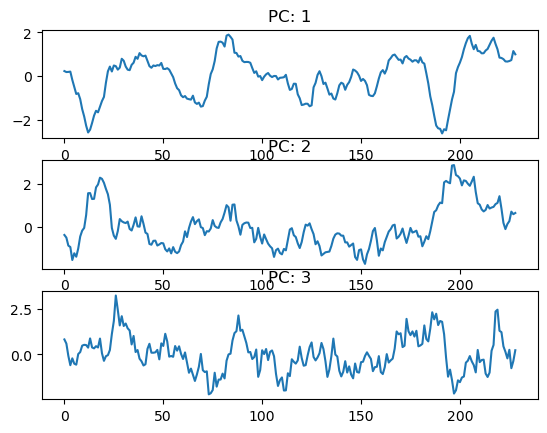

In [135]:
nrows=3
ncols=1
clevs=np.arange(-20,21,10)

for i in np.arange(3):
    plt.subplot(nrows,ncols,i+1)
    pcnorm=PC[:,i]/np.std(PC[:,i])
    plt.title('PC: '+str(i+1))
    plt.plot(pcnorm)